# Setup

In [ ]:
!pip -q install captum==0.6.0
!pip -q install shap
!pip install --quiet optuna
!pip install --quiet torchviz
!pip install --quiet causalml

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from functools import partial
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from captum.attr import KernelShap, IntegratedGradients
import shap
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from imblearn.under_sampling import ClusterCentroids
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.stats import norm

import warnings


from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from causalml.inference.meta import BaseRClassifier, BaseSClassifier, BaseTClassifier, BaseXClassifier, BaseSClassifier
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset import *
from causalml.metrics import *

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

# Functions

In [ ]:
class EarlyStopper:

    def __init__(self, patience=40, min_delta=0):
        """
          Initializes the EarlyStopper object.

          Parameters:
              patience (int, optional): Number of epochs to wait before stopping the training if the validation loss does not improve. Default is 40.
              min_delta (float, optional): Minimum change in validation loss to be considered as an improvement. Default is 0.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        """
          Checks if the training should be stopped based on the given validation loss.

          Parameters:
              validation_loss (float): Current validation loss.

          Returns:
              bool: True if training should be stopped, False otherwise.
        """
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False



def make_treatment_datasets(X,t,y):
  """
    Separates datasets for two different treatments.

    Parameters:
        X (array-like): Features matrix.
        t (array-like): Treatment assignment vector (0 or 1).
        y (array-like): Outcome vector.

    Returns:
        X1 (torch.Tensor): Features for treatment 1.
        Y1 (torch.Tensor): Outcome for treatment 1.
        X0 (torch.Tensor): Features for treatment 0.
        Y0 (torch.Tensor): Outcome for treatment 0.
  """
  # Separate datasets for two different treatments
  X1 = torch.tensor(X[t==1], dtype=torch.float32) # Features for treatment 1
  Y1 = torch.tensor(y[t==1], dtype=torch.float32) # Output for treatment 1


  X0 = torch.tensor(X[t==0], dtype=torch.float32) # Features for treatment 1
  Y0 = torch.tensor(y[t==0], dtype=torch.float32) # Output for treatment 1

  return X1,Y1,X0,Y0

def train_validation_dt(X,Y,T):
  """
    Splits data into train and validation sets.

    Parameters:
        X (array-like): Features matrix.
        Y (array-like): Outcome vector.
        T (array-like): Treatment assignment vector (0 or 1).

    Returns:
        X_train (array-like): Features for training.
        X_val (array-like): Features for validation.
        Y_train (array-like): Outcome for training.
        Y_val (array-like): Outcome for validation.
        T_train (array-like): Treatment assignment for training.
        T_val (array-like): Treatment assignment for validation.
  """
  # Split data to train and validation sets
  X_train, X_val, Y_train, Y_val, T_train, T_val = train_test_split(X, Y, T, test_size=0.2, random_state=42)

  return X_train, X_val, Y_train, Y_val, T_train, T_val

def compute_metrics(predictions, targets):
    """
      Computes classification metrics.

      Parameters:
          predictions (array-like or torch.Tensor): Predicted values.
          targets (array-like or torch.Tensor): True labels.

      Returns:
          accuracy (float): Accuracy score.
          precision (float): Precision score.
          recall (float): Recall score.
          f1 (float): F1 score.
    """
    predictions = predictions.numpy() if isinstance(predictions, torch.Tensor) else predictions
    targets = targets.numpy() if isinstance(targets, torch.Tensor) else targets
    binary_targets = (targets > 0.5).astype(int)
    binary_predictions = (predictions > 0.5).astype(int)

    accuracy = accuracy_score(binary_targets, binary_predictions)
    precision = precision_score(binary_targets, binary_predictions, average='macro')
    recall = recall_score(binary_targets, binary_predictions, average='macro')
    f1 = f1_score(binary_targets, binary_predictions, average='macro')

    return accuracy, precision, recall, f1

def compute_ate_ci(y0, y1, ate, alpha=0.05):

    """
      Computes the confidence interval of the Average Treatment Effect (ATE).

      Parameters:
          y0 (array-like): Outcome for untreated group.
          y1 (array-like): Outcome for treated group.
          ate (float): Estimated Average Treatment Effect.
          alpha (float, optional): Confidence level. Default is 0.05.

      Returns:
          lower_bound (float): Lower bound of the confidence interval.
          upper_bound (float): Upper bound of the confidence interval.
    """

    # Compute the variance of the outcome variable for treated and untreated groups
    var_Y_treated = np.var(y1)
    var_Y_untreated = np.var(y0)

    # Compute the number of treated and untreated individuals
    n_treated = len(y1)
    n_untreated = len(y0)

    # Compute the ATE standard error
    se_ate = np.sqrt(var_Y_treated / n_treated + var_Y_untreated / n_untreated)
    z_alpha_half = norm.ppf(1 - alpha / 2) # alpha confidence level (e.g., 0.05 for a 95% confidence interval).
    lower_bound = ate - z_alpha_half * se_ate
    upper_bound = ate + z_alpha_half * se_ate

    return lower_bound, upper_bound

# Causal Single Neural Network

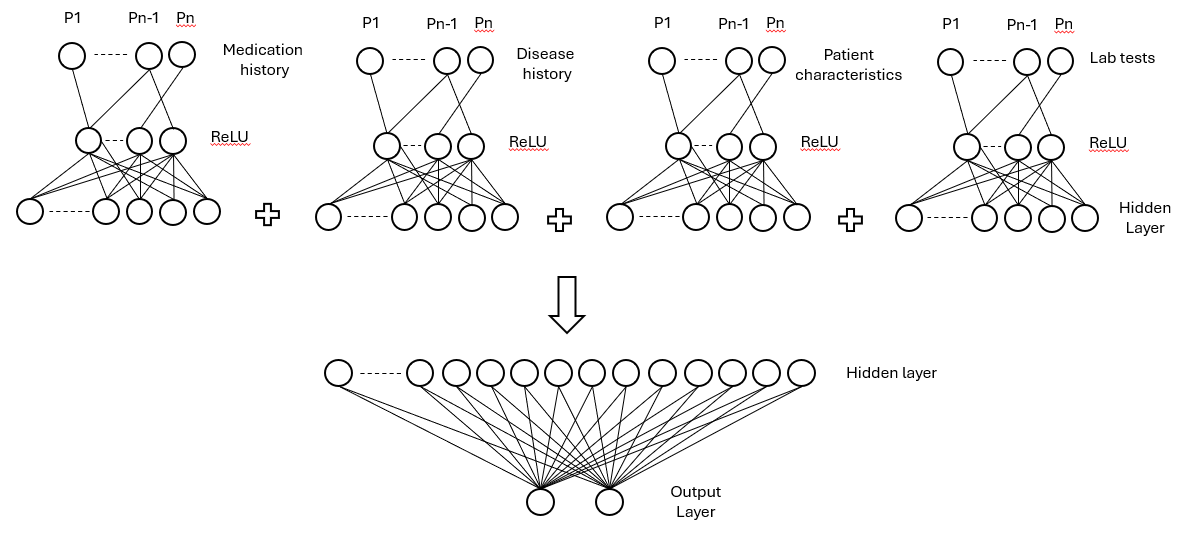

In [ ]:
class CSNN(nn.Module):
    def __init__(self, med_size, com_size, dem_size, lab_size, hidden_size, output_size, dropout_rate=0.7):
        """
          Initializes the CSNN neural network model.

          Parameters:
              med_size (int): Size of the medication input.
              com_size (int): Size of the comorbidities input.
              dem_size (int): Size of the patient characteristics input.
              lab_size (int): Size of the lab tests input.
              hidden_size (int): Size of the hidden layer in the neural network.
              output_size (int): Size of the output layer in the neural network.
              dropout_rate (float, optional): Dropout rate for the dropout layer. Default is 0.7.
        """
        super(CSNN, self).__init__()
        self.med = nn.Linear(med_size, hidden_size)
        self.relum = nn.ReLU()
        self.com = nn.Linear(com_size, hidden_size)
        self.reluc = nn.ReLU()
        self.dem = nn.Linear(dem_size, hidden_size)
        self.relud = nn.ReLU()
        self.lab = nn.Linear(lab_size, hidden_size)
        self.relul = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc1 = nn.Linear(hidden_size*4, output_size)

    def forward(self, x1,x2,x3,x4):
        """
          Forward pass through the CSNN neural network.

          Parameters:
              x1 (torch.Tensor): Input tensor for medication data.
              x2 (torch.Tensor): Input tensor for comorbidities data.
              x3 (torch.Tensor): Input tensor for demographics data.
              x4 (torch.Tensor): Input tensor for lab tests data.

          Returns:
              torch.Tensor: Output tensor from the neural network.
        """
        x1 = self.med(x1)
        x1 = self.relum(x1)
        x2 = self.com(x2)
        x2 = self.reluc(x2)
        x3 = self.dem(x3)
        x3 = self.relud(x3)
        x4 = self.lab(x4)
        x4 = self.relul(x4)
        x = torch.cat((x1, x2, x3, x4), 1)
        x = self.fc1(x)

        return x

def trainCSNN(model,med,com,dem,lab,y,t,learning_rate,l2,num_epochs,batch_size,ate_plot=True):

  """
    Trains the CSNN (Causal Deep Learning Neural Network) model.

    Parameters:
        model (CSNN): The CSNN model to be trained.
        med (torch.Tensor): Tensor containing medication data.
        com (torch.Tensor): Tensor containing comorbidities data.
        dem (torch.Tensor): Tensor containing patient characteristics data.
        lab (torch.Tensor): Tensor containing lab tests data.
        y (torch.Tensor): Tensor containing the target variable (outcome).
        t (torch.Tensor): Tensor containing the treatment variable.
        learning_rate (float): Learning rate for the optimizer.
        l2 (float): L2 regularization parameter.
        num_epochs (int): Number of epochs for training.
        batch_size (int): Batch size for training.
        ate_plot (bool, optional): Whether to plot the Average Treatment Effect (ATE) distribution. Default is True.

    Returns:
        float: The F1-score of the trained model.
  """

  # Define loss function, optimizer and early stopper
  criterion = nn.BCEWithLogitsLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay = l2)
  early_stopper = EarlyStopper(patience=20, min_delta=.01)

  # Split to train and validation set
  med_train, med_val, com_train, com_val, dem_train, dem_val, lab_train, lab_val, Y_train, Y_val, T_train, T_val = train_test_split(med,com,dem,lab,y,t,
                                                                                                                                    test_size=0.2, random_state=42 )
  med_train_dataset = torch.tensor(med_train, dtype=torch.float32)
  com_train_dataset = torch.tensor(com_train, dtype=torch.float32)
  dem_train_dataset = torch.tensor(dem_train, dtype=torch.float32)
  lab_train_dataset = torch.tensor(lab_train, dtype=torch.float32)

  med_val_dataset = torch.tensor(med_val, dtype=torch.float32)
  com_val_dataset = torch.tensor(com_val, dtype=torch.float32)
  dem_val_dataset = torch.tensor(dem_val, dtype=torch.float32)
  lab_val_dataset = torch.tensor(lab_val, dtype=torch.float32)

  Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
  Y_val_tensor = torch.tensor(Y_val, dtype=torch.float32)

  train_dataset = torch.utils.data.TensorDataset(med_train_dataset, com_train_dataset, dem_train_dataset, lab_train_dataset, Y_train_tensor)
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

  val_dataset = TensorDataset(med_val_dataset, com_val_dataset, dem_val_dataset, lab_val_dataset, Y_val_tensor)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

  train_pred = []
  model.train()
  for epoch in range(num_epochs):
      for in_med, in_com, in_dem, in_lab, targets in train_loader:
          optimizer.zero_grad()
          outputs = model(in_med,in_com,in_dem,in_lab)
          train_pred.append(outputs)
          loss = criterion(outputs.squeeze(), targets.float())
          if early_stopper.early_stop(loss):
              break
          loss.backward()
          optimizer.step()
      # print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}')

  model.eval()
  val_losses = []
  predictions = []
  targets_val = []
  with torch.no_grad():
      for in_med, in_com, in_dem, in_lab, targets in val_loader:
          outputs = model(in_med, in_com, in_dem, in_lab)
          val_loss = criterion(outputs.squeeze(), targets.float())
          val_losses.append(val_loss.item())
          predictions.append(outputs)
          targets_val.append(targets)
  avg_val_loss = sum(val_losses) / len(val_losses)
  print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}')

  # Concatenate lists of tensors into single tensors
  predictions = torch.cat(predictions)
  targets= torch.cat(targets_val)

  y1_pred = predictions[T_val==1]
  y0_pred = predictions[T_val==0]

  if ate_plot==True:
  # Plot distributions after matching
    pd.Series(y1_pred.squeeze()).plot.kde()
    pd.Series(y0_pred.squeeze()).plot.kde()

  cate_pred = np.mean(y1_pred.detach().numpy()) - np.mean(y0_pred.detach().numpy()) # Treatment effect
  lower, upper = compute_ate_ci(y0_pred.detach().numpy(), y1_pred.detach().numpy(), cate_pred, alpha=0.05) # Confidence intervals of treatment effect

  accuracy, precision, recall, f1 = compute_metrics(predictions, targets)
  print("Average treatment effect: ", cate_pred)
  print("95% CI:", lower,upper)
  print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

  return f1

# Single learner classifier
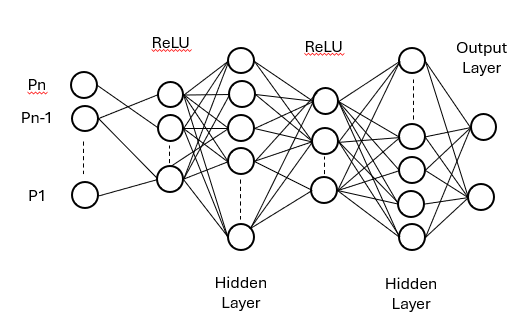

In [ ]:
class SLNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.7):
        """
          Neural network model with dropout for binary classification.

          Parameters:
              input_size (int): Number of input features.
              hidden_size (int): Number of units in the hidden layer.
              output_size (int): Number of units in the output layer.
              dropout_rate (float, optional): Dropout rate. Default is 0.7.
        """
        super(SLNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
          Forward pass of the neural network.

          Parameters:
              x (torch.Tensor): Input tensor.

          Returns:
              torch.Tensor: Output tensor.
        """
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)

        return x

def trainSLNN(model,X,y,t,learning_rate,l2,num_epochs,batch_size,ate_plot=True):
  """
    Train a single-layer neural network model for binary classification.

    Parameters:
        model (SLNN): Single-layer neural network model.
        X (numpy.ndarray): Input features.
        y (numpy.ndarray): Output labels.
        t (numpy.ndarray): Treatment indicators.
        learning_rate (float): Learning rate for the optimizer.
        l2 (float): L2 regularization strength.
        num_epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.
        ate_plot (bool, optional): Whether to plot average treatment effect. Default is True.

    Returns:
        float: F1-score of the model on the validation set.
  """

  # Define loss function, optimizer and early stopper
  criterion = nn.BCEWithLogitsLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay = l2)
  early_stopper = EarlyStopper(patience=20, min_delta=.01)

  # Split to train and validation set
  X_train, X_val, Y_train, Y_val, T_train, T_val = train_test_split(X,y,t,test_size=0.2, random_state=42 )
  X_train_dataset = torch.tensor(X_train, dtype=torch.float32)
  X_val_dataset = torch.tensor(X_val, dtype=torch.float32)

  Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
  Y_val_tensor = torch.tensor(Y_val, dtype=torch.float32)

  train_dataset = torch.utils.data.TensorDataset(X_train_dataset, Y_train_tensor)
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

  val_dataset = TensorDataset(X_val_dataset, Y_val_tensor)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

  train_pred = []
  model.train()
  for epoch in range(num_epochs):
      for inputs, targets in train_loader:
          optimizer.zero_grad()
          outputs = model(inputs)
          train_pred.append(outputs)
          loss = criterion(outputs.squeeze(), targets.float())
          if early_stopper.early_stop(loss):
              break
          loss.backward()
          optimizer.step()
      # print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}')

  model.eval()
  val_losses = []
  predictions = []
  targets_val = []
  with torch.no_grad():
      for inputs, targets in val_loader:
          outputs = model(inputs)
          val_loss = criterion(outputs.squeeze(), targets.float())
          val_losses.append(val_loss.item())
          predictions.append(outputs)
          targets_val.append(targets)
  avg_val_loss = sum(val_losses) / len(val_losses)
  print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}')

  # Concatenate lists of tensors into single tensors
  predictions = torch.cat(predictions)
  targets= torch.cat(targets_val)

  y1_pred = predictions[T_val==1]
  y0_pred = predictions[T_val==0]

  if ate_plot==True:
  # Plot distributions after matching
    pd.Series(y1_pred.squeeze()).plot.kde()
    pd.Series(y0_pred.squeeze()).plot.kde()

  cate_pred = np.mean(y1_pred.detach().numpy()) - np.mean(y0_pred.detach().numpy()) #Treatment effect
  lower, upper = compute_ate_ci(y0_pred.detach().numpy(), y1_pred.detach().numpy(), cate_pred, alpha=0.05) #Confidence intervals of treatment effect

  accuracy, precision, recall, f1 = compute_metrics(predictions, targets)
  print("Average treatment effect: ", cate_pred)
  print("95% CI:", lower,upper)
  print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

  return f1



# Benchmark meta learners
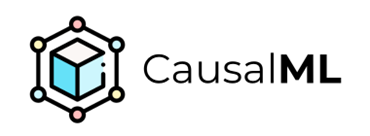

In [ ]:
# S Learner
learner_s = BaseSClassifier(learner=XGBClassifier())


# T Learner
learner_t = BaseTClassifier(learner=LGBMClassifier())


# X Learner with propensity score input
learner_x = BaseXClassifier(treatment_outcome_learner=XGBClassifier(random_state=42),
                            treatment_effect_learner=XGBRegressor(random_state=42),
                            control_outcome_learner=LGBMClassifier(random_state=42),
                            control_effect_learner=LGBMRegressor(random_state=42),)


# R Learner with propensity score input
learner_r = BaseRClassifier(outcome_learner=XGBClassifier(random_state=42),
                            effect_learner=XGBRegressor(random_state=42)
                            )

models = [learner_t,learner_r,learner_x,learner_s]


import numpy as np

def estimate_ate_classification(X,T,y, models):
    """
    Estimate the Average Treatment Effect (ATE) and confidence intervals for binary classification models.

    Args:
    - data (DataFrame): The dataset containing treatment, outcome, and features.
    - treatment_col (str): The name of the treatment column.
    - outcome_col (str): The name of the outcome column.
    - features (list): List of feature columns.
    - models (dict): Dictionary of classification models to be evaluated. Keys are model names, and values are model objects.

    Returns:
    - DataFrame: A DataFrame containing the average treatment effect (ATE), confidence intervals for ATE, and F1-score of each model.
    """

    # Initialize a DataFrame to store results
    results = pd.DataFrame(columns=['Model', 'ATE', 'ATE_CI_Lower', 'ATE_CI_Upper', 'F1-Score'])


    for model_class in models:
        model_name = str(model_class)[:15]

        # Instantiate the model
        model = model_class

        # Split data into train and test sets
        X_train, X_test, y_train, y_test, T_train, T_test = train_test_split(X, y, T, test_size=0.2, random_state=42)

        # Fit the model
        model.fit(X_train, T_train, y_train)

        # Predict treatment effect
        te = model.predict(X_test)

        # Calculate ATE
        ate = np.mean(te)

        # Estimate confidence intervals for ATE
        if 'BaseSClassifier' in model_name:
          ate, ate_ci_lower, ate_ci_upper = model.estimate_ate(X_test,y = y_test,treatment = T_test, return_ci=True)
        else:
          ate, ate_ci_lower, ate_ci_upper = model.estimate_ate(X_test,y = y_test,treatment = T_test)


        # Calculate F1-score
        y_pred = model.predict(X_test)
        acc, prec, rec, f1 = compute_metrics(y_pred, y_test)

        # Add results to DataFrame
        results = results.append({
            'Model': model_name,
            'ATE': ate[0],
            'ATE_CI_Lower': ate_ci_lower[0],
            'ATE_CI_Upper': ate_ci_upper[0],
            'F1-Score': f1
        }, ignore_index=True)

    return results

# Propensity score

In [ ]:
from imblearn.under_sampling import ClusterCentroids

# Define the neural network model for propensity score estimation
class PropensityNet(nn.Module):
    def __init__(self, input_size):
        """
          Neural network model for propensity score estimation.

          Parameters:
              input_size (int): Number of features in the input data.
        """
        super(PropensityNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        """
          Forward pass of the neural network.

          Parameters:
              x (torch.Tensor): Input data.

          Returns:
              torch.Tensor: Output of the neural network.
        """
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x


def trainPrNN(propensity_model, num_epochs):
    """
      Train the neural network model for propensity score estimation.

      Parameters:
          propensity_model (PropensityNet): Propensity score neural network model.
          num_epochs (int): Number of training epochs.
          X_tensor (torch.Tensor): Input features.
          T_tensor (torch.Tensor): Treatment indicators.

      Returns:
          numpy.ndarray: Propensity scores.
    """

    # Define loss function and optimizer for propensity score estimation
    criterion = nn.BCELoss()
    optimizer = optim.Adam(propensity_model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = propensity_model(X_tensor)
        loss = criterion(outputs.squeeze(), T_tensor)
        loss.backward()
        optimizer.step()
        # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    # Get propensity scores from the trained neural network model
    propensity_scores = propensity_model(X_tensor).detach().numpy().flatten()

    return propensity_scores


# Perform matching with propensity scores and trimming
def matching_with_propensity_score_and_trimming(X, T, Y, propensity_scores, trim=0.1):
    """
        Perform matching with propensity scores and trimming.

        Parameters:
            X (numpy.ndarray): Input features.
            T (numpy.ndarray): Treatment indicators.
            Y (numpy.ndarray): Outcome values.
            propensity_scores (numpy.ndarray): Propensity scores.
            trim (float, optional): Trim percentage for outlier removal. Default is 0.1.

        Returns:
            numpy.ndarray: Matched input features.
            numpy.ndarray: Matched treatment indicators.
            numpy.ndarray: Matched outcome values.
    """
    treated_indices = np.where(T == 1)[0]
    control_indices = np.where(T == 0)[0]

    # Compute distances between treated and control units based on propensity scores
    nn_treated = NearestNeighbors(n_neighbors=1).fit(propensity_scores[treated_indices].reshape(-1, 1))
    nn_control = NearestNeighbors(n_neighbors=1).fit(propensity_scores[control_indices].reshape(-1, 1))

    distances_treated, indices_treated = nn_treated.kneighbors(propensity_scores[control_indices].reshape(-1, 1))
    distances_control, indices_control = nn_control.kneighbors(propensity_scores[treated_indices].reshape(-1, 1))

    # Find matched pairs based on the closest propensity score
    matched_treated_indices = treated_indices
    matched_control_indices = control_indices[indices_control.flatten()]

    # Trim outliers based on propensity scores
    trimmed_indices_treated = np.where(np.abs(propensity_scores[matched_treated_indices] - np.mean(propensity_scores[matched_treated_indices])) <= trim)[0]
    trimmed_indices_control = np.where(np.abs(propensity_scores[matched_control_indices] - np.mean(propensity_scores[matched_control_indices])) <= trim)[0]

    # Concatenate matched data after trimming outliers
    matched_X = np.concatenate([X[matched_treated_indices[trimmed_indices_treated]], X[matched_control_indices[trimmed_indices_control]]])
    matched_T = np.concatenate([T[matched_treated_indices[trimmed_indices_treated]], T[matched_control_indices[trimmed_indices_control]]])
    matched_Y = np.concatenate([Y[matched_treated_indices[trimmed_indices_treated]], Y[matched_control_indices[trimmed_indices_control]]])

    # Undersample the majority class for each treatment group
    cc = ClusterCentroids(random_state=0)
    resample_X_1, resample_Y_1 = cc.fit_resample(matched_X[matched_T==1], matched_Y[matched_T==1])
    resample_X_0, resample_Y_0 = cc.fit_resample(matched_X[matched_T==0], matched_Y[matched_T==0])
    resample_T_1 = np.array([1] * len(resample_X_1))
    resample_T_0 = np.array([0] * len(resample_X_0))

    matched_X = np.concatenate((resample_X_1, resample_X_0))
    matched_Y = np.concatenate((resample_Y_1, resample_Y_0))
    matched_T = np.concatenate((resample_T_1, resample_T_0))

    return matched_X, matched_T, matched_Y


# Allopurinol

## Simethicone

In [ ]:
allopurinol_simethicone_AKI = pd.read_parquet(f'{work_dir}/allopurinol_simethicone_AKI.parquet.gzip')

allopurinol_simethicone_AKI['gender'] = allopurinol_simethicone_AKI['gender'].replace('F',1)
allopurinol_simethicone_AKI['gender'] = allopurinol_simethicone_AKI['gender'].replace('M',0)

column_dt = allopurinol_simethicone_AKI.drop(['y','t','subject_id'], axis=1)

ex_ls =  ['glucose','Big_bp', 'bicarbonate','bun','BMI (kg/m2)','Weight (Lbs)',
 'chloride','anchor_age', 'sodium','potassium', 'Small_bp','creatinine','aniongap']

sc = StandardScaler()
sc_lst = ['glucose','Big_bp', 'bicarbonate','bun','BMI (kg/m2)','Weight (Lbs)',
 'chloride','sodium','potassium', 'Small_bp','creatinine','aniongap']
column_dt[sc_lst] = sc.fit_transform(column_dt[sc_lst])

for cl in list(column_dt.columns):
  if cl not in ex_ls:
    column_dt.loc[allopurinol_simethicone_AKI[cl]>1, cl] = 1

column_dt.drop(['charlson_comorbidity_index','BMI (kg/m2)'], axis=1, inplace=True)

lab = ["Big_bp","Small_bp","glucose","sodium","creatinine",
                     "potassium","bun","bicarbonate","chloride","aniongap"]
dem = ["Weight (Lbs)","gender","anchor_age"]
com = ['congestive_heart_failure', 'renal_disease', 'diabetes_without_cc','chronic_pulmonary_disease',
      'myocardial_infarct','diabetes_with_cc','peripheral_vascular_disease','cerebrovascular_disease',
      'malignant_cancer','mild_liver_disease','metastatic_solid_tumor','rheumatic_disease',
       'peptic_ulcer_disease','dementia','paraplegia','severe_liver_disease','aids']

lab_dem_com = lab + dem + com
med = []
for col in column_dt.columns:
  if col not in lab_dem_com:
    med.append(col)

y=np.array(allopurinol_simethicone_AKI['y']).astype('float32').squeeze() #most GPUs only compute 32-bit floats
t=np.array(allopurinol_simethicone_AKI['t']).astype('float32').squeeze()
X=np.array(column_dt).astype('float32')

column_dt.name = 'allopurinol_simethicone_AKI'

In [ ]:
column_dt

,L04AA13,L01BC01,J01XX09,C03CA01,aids,Small_bp,severe_liver_disease,bun,L01CA02,L01AA01,...,J05AF07,C09AA13,L01AD01,L01FA01,L01XG01,C03BA08,L04AB01,anchor_age,L01DB02,C09CA03
0,0,0,0,1,0,0.596265,0,0.718765,0,0,...,0,0,0,0,0,0,0,87,0,0
1,0,0,0,1,0,-1.417429,0,1.871653,0,0,...,0,0,0,0,0,1,0,53,0,1
2,0,0,0,1,0,-0.947567,0,1.320085,0,0,...,0,0,0,0,0,0,0,64,0,0
3,0,0,0,1,0,0.596265,0,1.858854,0,0,...,0,0,0,0,0,0,0,47,0,0
4,0,1,0,1,0,-0.813321,0,2.280164,0,0,...,0,0,0,0,0,0,0,63,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,0,0,0,0,0,-1.954414,0,-0.910678,0,0,...,0,0,0,0,0,0,0,30,0,0
2325,0,0,0,0,0,-1.887290,0,-0.532993,0,0,...,0,0,0,0,0,0,0,38,0,0
2326,0,0,0,0,0,-0.007843,0,-0.856723,0,0,...,0,0,0,0,0,0,0,33,0,0
2327,0,0,0,1,0,2.005850,0,1.193569,0,0,...,0,0,0,0,0,0,0,79,0,1


In [ ]:
# Convert numpy arrays to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
T_tensor = torch.tensor(t, dtype=torch.float32)

# Instantiate the neural network model
input_size = X.shape[1]
propensity_model = PropensityNet(input_size)
num_epochs = 100

propensity_scores = trainPrNN(propensity_model, num_epochs)
matched_X, matched_T, matched_Y = matching_with_propensity_score_and_trimming(X, t, y, propensity_scores)

matched_X = pd.DataFrame(matched_X)
matched_X.columns=column_dt.columns
matched_X

labf = matched_X[lab]
demf = matched_X[dem]
comf = matched_X[com]
medf = matched_X[med]

labf=np.array(labf).astype('float32')
demf=np.array(demf).astype('float32')
comf=np.array(comf).astype('float32')
medf=np.array(medf).astype('float32')

matched_X=np.array(matched_X).astype('float32')

Epoch [100/100], Loss: 0.3250


### CSNN

Epoch [80/80], Validation Loss: 0.2691
Average treatment effect:  1.5414848
95% CI: 0.3869347714091578 2.6960348941181858
Accuracy: 0.8990, Precision: 0.9026, Recall: 0.8967, F1-score: 0.8981


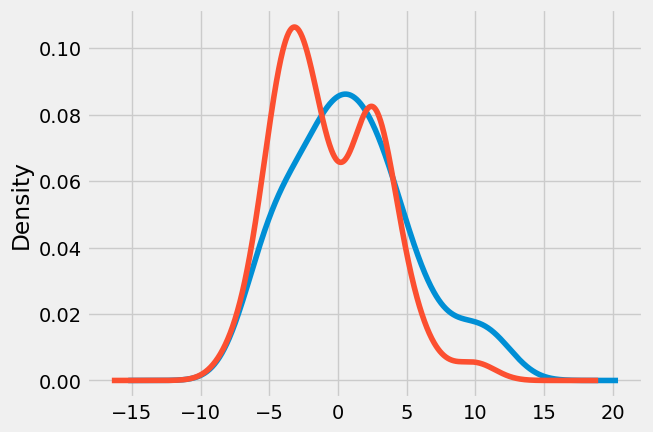

In [ ]:
torch.manual_seed(789)
np.random.seed(789)

med_size = medf.shape[1]
lab_size = labf.shape[1]
dem_size = demf.shape[1]
com_size = comf.shape[1]
hidden_size = 68
output_size = 1
batch_size = 64
learning_rate=0.006731882600268923
l2=0.0008261646138922126
num_epochs = 80

model = CSNN(med_size=med_size, com_size=com_size, dem_size=dem_size,
                   lab_size=lab_size, hidden_size=hidden_size, output_size=output_size)
shap_values_ls, f1 = trainCSNN(model,medf,comf,demf,labf,matched_Y,matched_T,learning_rate,l2,num_epochs,
          batch_size,ate_plot=True)

### Meta learners

In [ ]:
allo_sim = estimate_ate_classification(matched_X,matched_T,matched_Y, models)
allo_sim

,Model,ATE,ATE_CI_Lower,ATE_CI_Upper,F1-Score
0,BaseTClassifier,-0.073542,-0.153385,0.006302,0.514299
1,BaseRClassifier,-0.041121,-0.054754,-0.027489,0.481047
2,BaseXClassifier,-0.416572,-0.483105,-0.350039,0.345508
3,BaseSClassifier,-0.046388,-0.063220,-0.029557,0.344371


In [ ]:
matched_X

,L04AA13,L01BC01,J01XX09,C03CA01,aids,Small_bp,severe_liver_disease,bun,L01CA02,L01AA01,...,J05AF07,C09AA13,L01AD01,L01FA01,L01XG01,C03BA08,L04AB01,anchor_age,L01DB02,C09CA03
0,0.0,0.000000e+00,3.333333e-01,1.000000,0.0,-0.432956,0.0,0.366258,0.0,0.000000e+00,...,0.0,-9.313226e-10,0.0,0.0,0.0,0.0,0.0,81.333336,-9.313226e-10,-7.450581e-09
1,0.0,0.000000e+00,0.000000e+00,0.000000,0.0,1.625486,0.0,0.096483,0.0,0.000000e+00,...,0.0,-9.313226e-10,0.0,0.0,0.0,0.0,0.0,64.333336,-9.313226e-10,-7.450581e-09
2,0.0,0.000000e+00,0.000000e+00,0.000000,0.0,0.529142,0.0,0.303311,0.0,0.000000e+00,...,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,43.000000,0.000000e+00,0.000000e+00
3,0.0,1.000000e+00,5.000000e-01,1.000000,0.0,-0.142090,0.0,-0.694858,0.5,1.000000e+00,...,0.0,0.000000e+00,0.5,0.0,0.0,0.0,0.0,21.500000,5.000000e-01,0.000000e+00
4,0.0,-3.725290e-09,-3.725290e-09,0.333333,0.0,0.462018,0.0,-0.191277,0.0,-7.450581e-09,...,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,68.500000,0.000000e+00,-7.450581e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981,0.0,0.000000e+00,0.000000e+00,1.000000,0.0,2.072973,0.0,1.463344,0.0,0.000000e+00,...,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,72.000000,0.000000e+00,0.000000e+00
982,0.0,0.000000e+00,0.000000e+00,1.000000,0.0,0.059280,0.0,2.542446,0.0,0.000000e+00,...,0.0,0.000000e+00,0.0,0.0,0.0,1.0,0.0,74.000000,0.000000e+00,0.000000e+00
983,0.0,0.000000e+00,1.000000e+00,1.000000,0.0,1.535988,0.0,0.546108,0.0,0.000000e+00,...,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,85.000000,0.000000e+00,0.000000e+00
984,0.0,0.000000e+00,0.000000e+00,1.000000,0.0,-0.410582,0.0,0.060513,0.0,0.000000e+00,...,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,72.000000,0.000000e+00,1.000000e+00


### SLNN

Epoch [80/80], Validation Loss: 0.2807
Average treatment effect:  0.79681134
95% CI: 0.03207308427415134 1.5615496002046085
Accuracy: 0.8889, Precision: 0.8890, Recall: 0.8881, F1-score: 0.8885


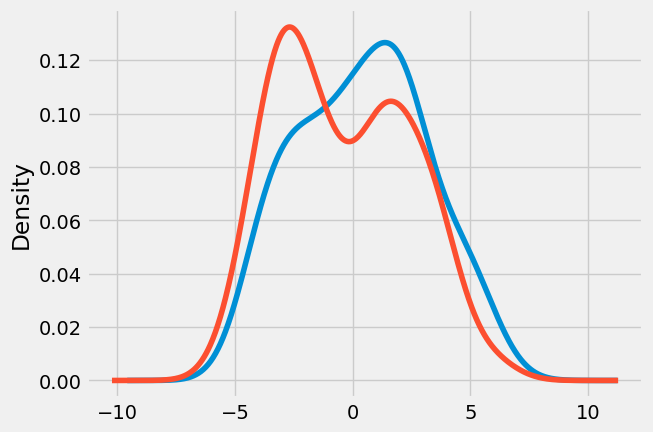

In [ ]:
torch.manual_seed(789)
np.random.seed(789)

input_size = matched_X.shape[1]

hidden_size = 91
output_size = 1
batch_size = 128
learning_rate=0.004536647513090321
l2=0.0008975696700060733
num_epochs = 80

model = SLNN(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
f1 = trainSLNN(model,matched_X,matched_Y,matched_T,learning_rate,l2,num_epochs,
          batch_size,ate_plot=True)

### Balance before matching

<Axes: title={'center': 'Standardized Difference in Means'}, ylabel='covariate'>

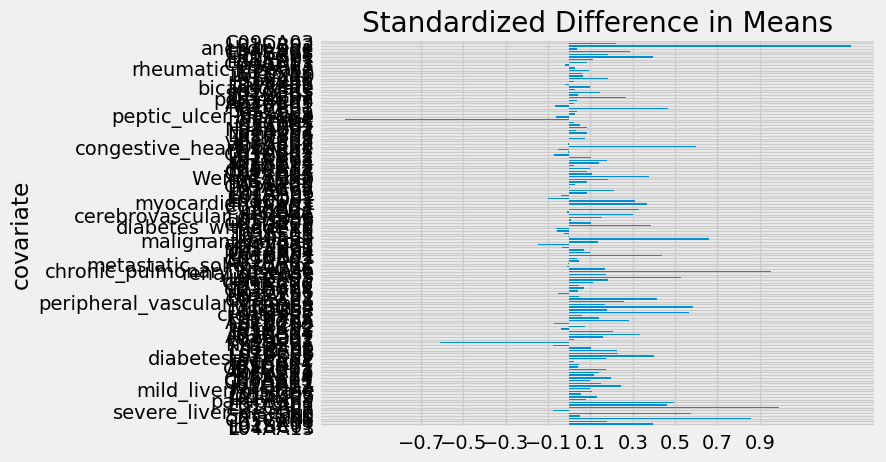

In [ ]:
X_df = pd.DataFrame(X)
X_df.columns = column_dt.columns

smd = (X_df[t==1].mean() - X_df[t==0].mean()).divide(
    np.sqrt((X_df[t==1].std() ** 2 + X_df[t==0].std() ** 2) / 2))

smd.plot.barh(title='Standardized Difference in Means',
           xlabel='covariate',ylabel='standardized difference in means',
           xticks=np.arange(-0.7,1,.2))

### Balance after matching

<Axes: title={'center': 'Standardized Difference in Means'}, ylabel='covariate'>

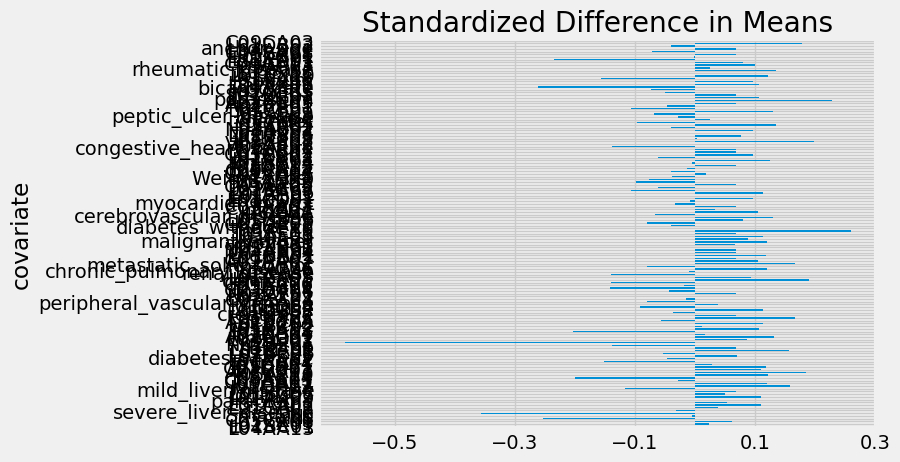

In [ ]:
matched_X_df = pd.DataFrame(matched_X)
matched_X_df.columns = column_dt.columns

smd = (matched_X_df[matched_T==1].mean() - matched_X_df[matched_T==0].mean()).divide(
    np.sqrt((matched_X_df[matched_T==1].std() ** 2 + matched_X_df[matched_T==0].std() ** 2) / 2))

smd.plot.barh(title='Standardized Difference in Means',
           xlabel='covariate',ylabel='standardized difference in means',
           xticks=np.arange(-0.5,0.5,.2))

## Prochlorperazine

In [ ]:
allopurinol_prochlorperazine_AKI = pd.read_parquet(f'{work_dir}/allopurinol_prochlorperazine_AKI.parquet.gzip')

allopurinol_prochlorperazine_AKI['gender'] = allopurinol_prochlorperazine_AKI['gender'].replace('F',1)
allopurinol_prochlorperazine_AKI['gender'] = allopurinol_prochlorperazine_AKI['gender'].replace('M',0)

column_dt = allopurinol_prochlorperazine_AKI.drop(['y','t','subject_id'], axis=1)

ex_ls =  ['glucose','Big_bp', 'bicarbonate','bun','BMI (kg/m2)','Weight (Lbs)',
 'chloride','anchor_age', 'sodium','potassium', 'Small_bp','creatinine','aniongap']

sc = StandardScaler()
sc_lst = ['glucose','Big_bp', 'bicarbonate','bun','BMI (kg/m2)','Weight (Lbs)',
 'chloride','sodium','potassium', 'Small_bp','creatinine','aniongap']
column_dt[sc_lst] = sc.fit_transform(column_dt[sc_lst])

for cl in list(column_dt.columns):
  if cl not in ex_ls:
    column_dt.loc[allopurinol_prochlorperazine_AKI[cl]>1, cl] = 1

column_dt.drop(['charlson_comorbidity_index','BMI (kg/m2)'], axis=1, inplace=True)

lab = ["Big_bp","Small_bp","glucose","sodium","creatinine",
                     "potassium","bun","bicarbonate","chloride","aniongap"]
dem = ["Weight (Lbs)","gender","anchor_age"]
com = ['congestive_heart_failure', 'renal_disease', 'diabetes_without_cc','chronic_pulmonary_disease',
      'myocardial_infarct','diabetes_with_cc','peripheral_vascular_disease','cerebrovascular_disease',
      'malignant_cancer','mild_liver_disease','metastatic_solid_tumor','rheumatic_disease',
       'peptic_ulcer_disease','dementia','paraplegia','severe_liver_disease','aids']

lab_dem_com = lab + dem + com
med = []
for col in column_dt.columns:
  if col not in lab_dem_com:
    med.append(col)

y=np.array(allopurinol_prochlorperazine_AKI['y']).astype('float32').squeeze() #most GPUs only compute 32-bit floats
t=np.array(allopurinol_prochlorperazine_AKI['t']).astype('float32').squeeze()
X=np.array(column_dt).astype('float32')

column_dt.name = 'allopurinol_prochlorperazine_AKI'

In [ ]:
column_dt

,L04AA13,L01BC01,J01XX09,C03CA01,aids,Small_bp,severe_liver_disease,bun,L01CA02,L01AA01,...,J05AF07,C09AA13,L01AD01,L01FA01,L01XG01,C03BA08,L04AB01,anchor_age,L01DB02,C09CA03
0,0,0,0,1,0,0.469042,0,0.638582,0,0,...,0,0,0,0,0,0,0,87,0,0
1,0,0,0,1,0,-1.628036,0,1.783783,0,0,...,0,0,0,0,0,1,0,53,0,1
2,0,0,0,1,0,-1.138718,0,1.235892,0,0,...,0,0,0,0,0,0,0,64,0,0
3,0,0,0,1,0,0.469042,0,1.771069,0,0,...,0,0,0,0,0,0,0,47,0,0
4,0,1,0,1,0,-0.998913,0,2.189570,0,0,...,0,0,0,0,0,0,0,63,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011,0,0,0,0,0,-0.229984,0,-0.819210,0,0,...,0,0,0,0,0,0,0,64,0,0
2012,0,0,0,0,0,0.469042,0,-0.872805,0,0,...,0,0,0,0,0,0,0,64,0,0
2013,0,0,0,0,0,-0.579497,0,-0.926400,0,0,...,1,0,0,0,0,0,0,49,0,0
2014,0,1,0,1,0,-0.789205,0,-0.551233,1,1,...,0,0,1,0,0,0,0,62,0,0


In [ ]:
# Convert numpy arrays to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
T_tensor = torch.tensor(t, dtype=torch.float32)

# Instantiate the neural network model
input_size = X.shape[1]
propensity_model = PropensityNet(input_size)
num_epochs = 100

propensity_scores = trainPrNN(propensity_model, num_epochs)
matched_X, matched_T, matched_Y = matching_with_propensity_score_and_trimming(X, t, y, propensity_scores)

matched_X = pd.DataFrame(matched_X)
matched_X.columns=column_dt.columns
matched_X

print(matched_X)

labf = matched_X[lab]
demf = matched_X[dem]
comf = matched_X[com]
medf = matched_X[med]

labf=np.array(labf).astype('float32')
demf=np.array(demf).astype('float32')
comf=np.array(comf).astype('float32')
medf=np.array(medf).astype('float32')

matched_X=np.array(matched_X).astype('float32')

Epoch [100/100], Loss: 0.3599
     L04AA13       L01BC01       J01XX09   C03CA01      aids  Small_bp  \
0        0.0  0.000000e+00 -7.450581e-09  0.666667  0.000000  0.562245   
1        0.0  7.450581e-09  0.000000e+00  0.111111  0.111111 -0.074645   
2        0.0  0.000000e+00  5.000000e-01  1.000000  0.000000 -0.684351   
3        0.0  0.000000e+00  0.000000e+00  1.000000  0.000000  1.447678   
4        0.0  0.000000e+00  0.000000e+00  0.375000  0.000000  0.547682   
..       ...           ...           ...       ...       ...       ...   
767      0.0  0.000000e+00  0.000000e+00  0.000000  0.000000 -0.229984   
768      0.0  0.000000e+00  0.000000e+00  1.000000  0.000000  0.189431   
769      0.0  0.000000e+00  0.000000e+00  1.000000  0.000000  0.119529   
770      0.0  0.000000e+00  1.000000e+00  1.000000  0.000000 -2.117354   
771      0.0  0.000000e+00  1.000000e+00  1.000000  0.000000 -0.789205   

     severe_liver_disease       bun       L01CA02       L01AA01  ...  J05AF07  \


### CSNN

Epoch [62/62], Validation Loss: 0.4830
Average treatment effect:  1.0049361
95% CI: -0.7584674523304167 2.768339650435275
Accuracy: 0.8903, Precision: 0.8904, Recall: 0.8902, F1-score: 0.8902


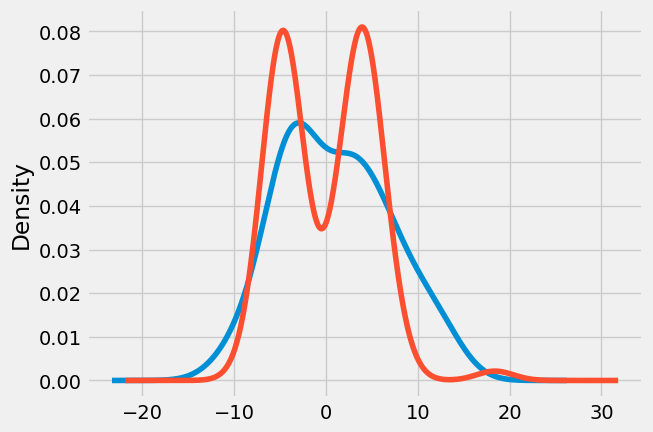

In [ ]:
torch.manual_seed(129)
np.random.seed(129)

med_size = medf.shape[1]
lab_size = labf.shape[1]
dem_size = demf.shape[1]
com_size = comf.shape[1]
hidden_size = 63
output_size = 1
batch_size = 128
learning_rate=0.005308976724704847
l2=0.0009098435782486335
num_epochs = 62

model = CSNN(med_size=med_size, com_size=com_size, dem_size=dem_size,
                   lab_size=lab_size, hidden_size=hidden_size, output_size=output_size)
f1 = trainCSNN(model,medf,comf,demf,labf,matched_Y,matched_T,learning_rate,l2,num_epochs,
          batch_size,ate_plot=True)

### Meta learners

In [ ]:
allo_proc = estimate_ate_classification(matched_X,matched_T,matched_Y, models)
allo_proc

,Model,ATE,ATE_CI_Lower,ATE_CI_Upper,F1-Score
0,BaseTClassifier,-0.086952,-0.175638,0.001733,0.393208
1,BaseRClassifier,-0.118112,-0.137544,-0.098679,0.501788
2,BaseXClassifier,-0.239585,-0.299963,-0.179207,0.349406
3,BaseSClassifier,0.002188,-0.008040,0.012416,0.329004


### SLNN

Epoch [39/39], Validation Loss: 0.4189
Average treatment effect:  0.5779153
95% CI: -0.6503734060310302 1.8062040277503906
Accuracy: 0.8452, Precision: 0.8469, Recall: 0.8459, F1-score: 0.8451


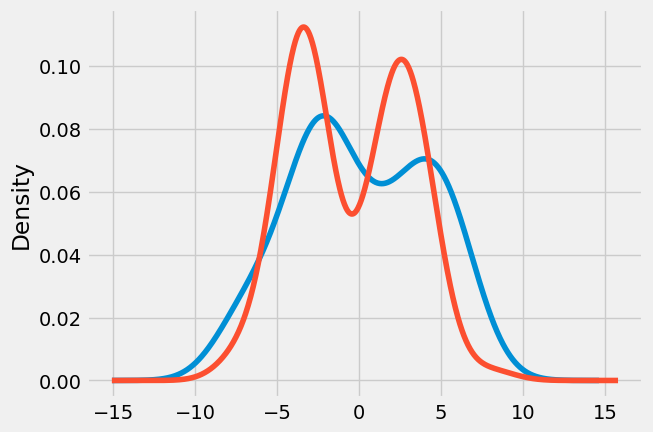

In [ ]:
torch.manual_seed(121)
np.random.seed(121)

input_size = matched_X.shape[1]

hidden_size = 91
output_size = 1
batch_size = 64
learning_rate=0.0018349357463653866
l2=0.0009770664984045743
num_epochs = 39

model = SLNN(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
f1 = trainSLNN(model,matched_X,matched_Y,matched_T,learning_rate,l2,num_epochs,
          batch_size,ate_plot=True)

### Balance before matching

<Axes: title={'center': 'Standardized Difference in Means'}, ylabel='covariate'>

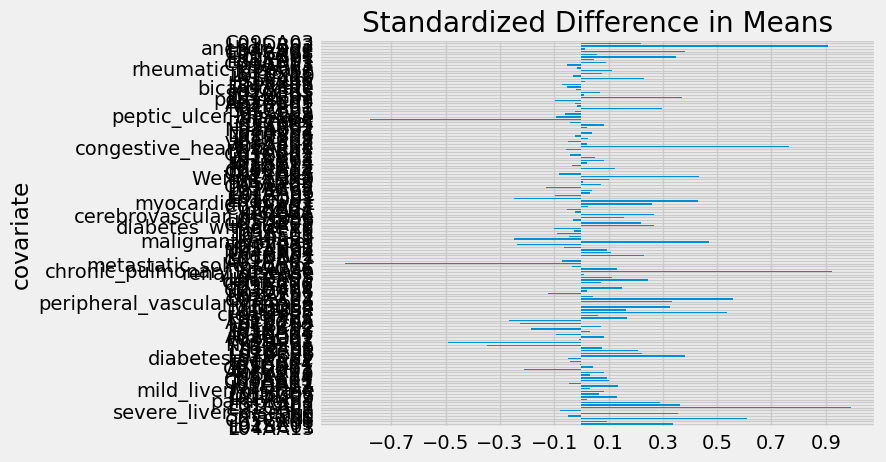

In [ ]:
X_df = pd.DataFrame(X)
X_df.columns = column_dt.columns

smd = (X_df[t==1].mean() - X_df[t==0].mean()).divide(
    np.sqrt((X_df[t==1].std() ** 2 + X_df[t==0].std() ** 2) / 2))

smd.plot.barh(title='Standardized Difference in Means',
           xlabel='covariate',ylabel='standardized difference in means',
           xticks=np.arange(-0.7,1,.2))

### Balance after matching

<Axes: title={'center': 'Standardized Difference in Means'}, ylabel='covariate'>

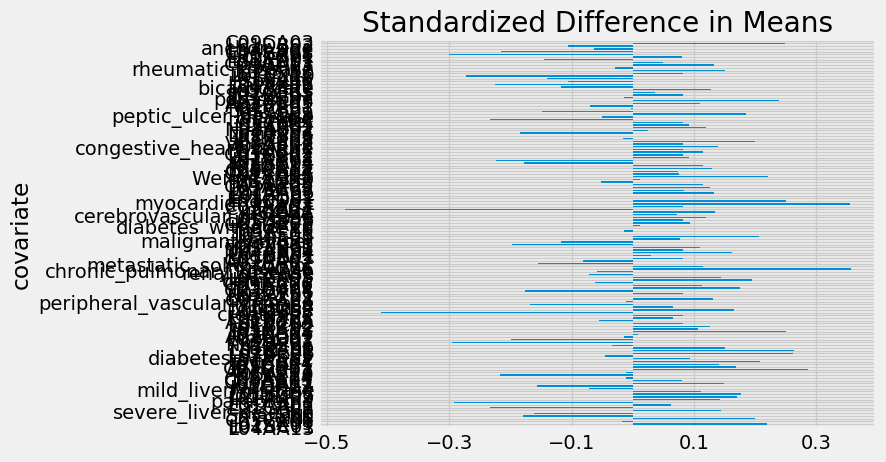

In [ ]:
matched_X_df = pd.DataFrame(matched_X)
matched_X_df.columns = column_dt.columns

smd = (matched_X_df[matched_T==1].mean() - matched_X_df[matched_T==0].mean()).divide(
    np.sqrt((matched_X_df[matched_T==1].std() ** 2 + matched_X_df[matched_T==0].std() ** 2) / 2))

smd.plot.barh(title='Standardized Difference in Means',
           xlabel='covariate',ylabel='standardized difference in means',
           xticks=np.arange(-0.5,0.5,.2))

## Lactulose

In [ ]:
allopurinol_lactulose_AKI = pd.read_parquet(f'{work_dir}/allopurinol_lactulose_AKI.parquet.gzip')

allopurinol_lactulose_AKI['gender'] = allopurinol_lactulose_AKI['gender'].replace('F',1)
allopurinol_lactulose_AKI['gender'] = allopurinol_lactulose_AKI['gender'].replace('M',0)

column_dt = allopurinol_lactulose_AKI.drop(['y','t','subject_id'], axis=1)

ex_ls =  ['glucose','Big_bp', 'bicarbonate','bun','BMI (kg/m2)','Weight (Lbs)',
 'chloride','anchor_age', 'sodium','potassium', 'Small_bp','creatinine','aniongap']

sc = StandardScaler()
sc_lst = ['glucose','Big_bp', 'bicarbonate','bun','BMI (kg/m2)','Weight (Lbs)',
 'chloride','sodium','potassium', 'Small_bp','creatinine','aniongap']
column_dt[sc_lst] = sc.fit_transform(column_dt[sc_lst])

for cl in list(column_dt.columns):
  if cl not in ex_ls:
    column_dt.loc[allopurinol_lactulose_AKI[cl]>1, cl] = 1

column_dt.drop(['charlson_comorbidity_index','BMI (kg/m2)'], axis=1, inplace=True)

lab = ["Big_bp","Small_bp","glucose","sodium","creatinine",
                     "potassium","bun","bicarbonate","chloride","aniongap"]
dem = ["Weight (Lbs)","gender","anchor_age"]
com = ['congestive_heart_failure', 'renal_disease', 'diabetes_without_cc','chronic_pulmonary_disease',
      'myocardial_infarct','diabetes_with_cc','peripheral_vascular_disease','cerebrovascular_disease',
      'malignant_cancer','mild_liver_disease','metastatic_solid_tumor','rheumatic_disease',
       'peptic_ulcer_disease','dementia','paraplegia','severe_liver_disease','aids']

lab_dem_com = lab + dem + com
med = []
for col in column_dt.columns:
  if col not in lab_dem_com:
    med.append(col)

y=np.array(allopurinol_lactulose_AKI['y']).astype('float32').squeeze() #most GPUs only compute 32-bit floats
t=np.array(allopurinol_lactulose_AKI['t']).astype('float32').squeeze()
X=np.array(column_dt).astype('float32')

column_dt.name = 'allopurinol_lactulose_AKI'

In [ ]:
column_dt

,L04AA13,L01BC01,J01XX09,C03CA01,aids,Small_bp,severe_liver_disease,bun,L01CA02,L01AA01,...,J05AF07,C09AA13,L01AD01,L01FA01,L01XG01,C03BA08,L04AB01,anchor_age,L01DB02,C09CA03
0,0,0,0,1,0,0.431138,0,0.367192,0,0,...,0,0,0,0,0,0,0,87,0,0
1,0,0,0,1,0,-1.592753,0,1.465524,0,0,...,0,0,0,0,0,1,0,53,0,1
2,0,0,0,1,0,-1.120512,0,0.940056,0,0,...,0,0,0,0,0,0,0,64,0,0
3,0,0,0,1,0,0.431138,0,1.453331,0,0,...,0,0,0,0,0,0,0,47,0,0
4,0,1,0,1,0,-0.985586,0,1.854703,0,0,...,0,0,0,0,0,0,0,63,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,0,0,0,0,0,-0.580807,0,-0.979535,0,0,...,1,0,0,0,0,0,0,49,0,0
979,0,0,0,0,0,-0.850660,1,-1.185143,0,0,...,0,0,0,0,0,0,0,57,0,0
980,0,1,0,1,0,-0.783197,0,-0.773928,1,1,...,0,0,1,0,0,0,0,62,0,0
981,0,1,0,1,0,0.228749,0,-0.825330,1,1,...,0,0,1,1,0,0,0,61,0,0


In [ ]:
# Convert numpy arrays to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
T_tensor = torch.tensor(t, dtype=torch.float32)

# Instantiate the neural network model
input_size = X.shape[1]
propensity_model = PropensityNet(input_size)
num_epochs = 100

propensity_scores = trainPrNN(propensity_model, num_epochs)
matched_X, matched_T, matched_Y = matching_with_propensity_score_and_trimming(X, t, y, propensity_scores)

matched_X = pd.DataFrame(matched_X)
matched_X.columns=column_dt.columns
print(matched_X)

labf = matched_X[lab]
demf = matched_X[dem]
comf = matched_X[com]
medf = matched_X[med]

labf=np.array(labf).astype('float32')
demf=np.array(demf).astype('float32')
comf=np.array(comf).astype('float32')
medf=np.array(medf).astype('float32')

matched_X=np.array(matched_X).astype('float32')

Epoch [100/100], Loss: 0.3746
      L04AA13   L01BC01   J01XX09   C03CA01  aids  Small_bp  \
0         0.0  0.000000  0.500000  0.000000   0.0  0.161286   
1         0.0  0.000000  0.000000  1.000000   0.0 -0.580807   
2         0.0  0.000000  0.000000  0.000000   0.0 -1.120512   
3         0.0  0.000000  0.000000  0.000000   0.0 -0.378418   
4         0.0  0.000000  0.000000  0.250000   0.0  1.156366   
...       ...       ...       ...       ...   ...       ...   
1153      0.0  0.000000  0.000000  0.000000   0.0 -1.053049   
1154      0.0  0.000000  0.000000  0.000000   0.0  0.498601   
1155      0.0  0.026163  0.037791  0.026163   0.0  0.380933   
1156      0.0  0.000000  0.000000  0.000000   0.0 -1.187975   
1157      0.0  0.000000  0.000000  0.000000   0.0 -0.243492   

      severe_liver_disease       bun  L01CA02  L01AA01  ...  J05AF07  C09AA13  \
0                 0.000000  0.819528      0.0      0.0  ...      0.0      0.0   
1                 0.000000 -0.311312      0.0      

### CSNN

Epoch [95/95], Validation Loss: 0.2487
Average treatment effect:  1.3765002
95% CI: 0.16411296853498825 2.5888875292830047
Accuracy: 0.8966, Precision: 0.9030, Recall: 0.8955, F1-score: 0.8959


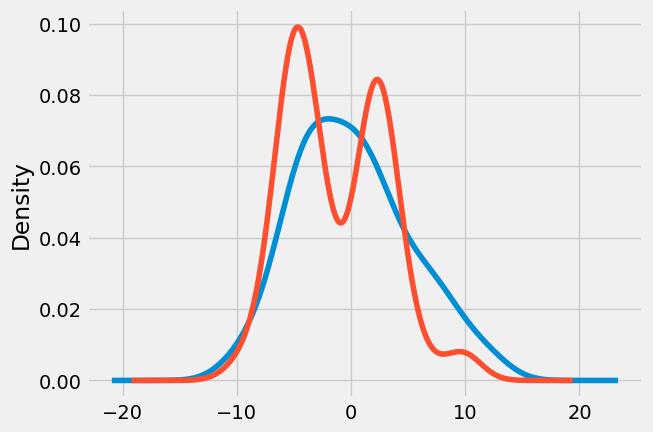

In [ ]:
torch.manual_seed(122)
np.random.seed(122)

med_size = medf.shape[1]
lab_size = labf.shape[1]
dem_size = demf.shape[1]
com_size = comf.shape[1]
hidden_size = 169
output_size = 1
batch_size = 128
learning_rate=0.004687539560885426
l2=0.0007186978701331411
num_epochs = 95

model = CSNN(med_size=med_size, com_size=com_size, dem_size=dem_size,
                   lab_size=lab_size, hidden_size=hidden_size, output_size=output_size)
f1 = trainCSNN(model,medf,comf,demf,labf,matched_Y,matched_T,learning_rate,l2,num_epochs,
          batch_size,ate_plot=True)

### Meta learners

In [ ]:
allo_lac = estimate_ate_classification(matched_X,matched_T,matched_Y, models)
allo_lac

,Model,ATE,ATE_CI_Lower,ATE_CI_Upper,F1-Score
0,BaseTClassifier,-0.226066,-0.305014,-0.147117,0.563636
1,BaseRClassifier,-0.060804,-0.067853,-0.053756,0.475309
2,BaseXClassifier,-0.551251,-0.606955,-0.495547,0.356322
3,BaseSClassifier,-0.024652,-0.035493,-0.013810,0.337143


### SLNN

Epoch [93/93], Validation Loss: 0.2649
Average treatment effect:  0.42108914
95% CI: -0.41506873455457927 1.2572470196764969
Accuracy: 0.9009, Precision: 0.9065, Recall: 0.8999, F1-score: 0.9003


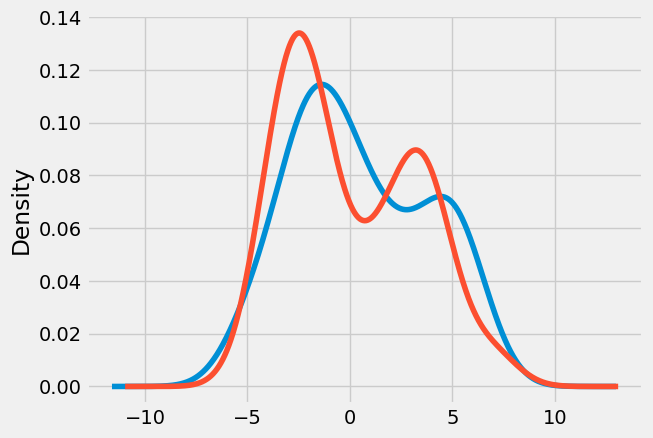

In [ ]:
torch.manual_seed(122)
np.random.seed(122)


input_size = matched_X.shape[1]

hidden_size = 79
output_size = 1
batch_size = 64
learning_rate=0.0066733188927964775
l2=0.0009113383563127057
num_epochs = 93


model = SLNN(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
f1 = trainSLNN(model,matched_X,matched_Y,matched_T,learning_rate,l2,num_epochs,
          batch_size,ate_plot=True)

### Balance before matching

<Axes: title={'center': 'Standardized Difference in Means'}, ylabel='covariate'>

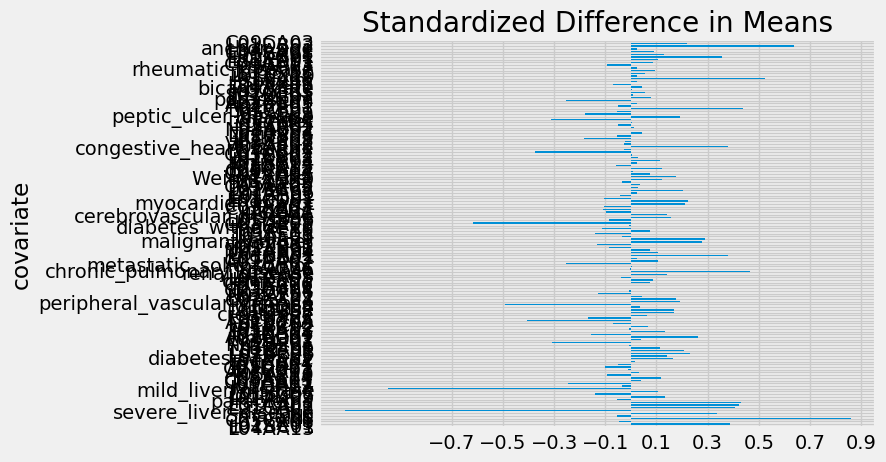

In [ ]:
X_df = pd.DataFrame(X)
X_df.columns = column_dt.columns

smd = (X_df[t==1].mean() - X_df[t==0].mean()).divide(
    np.sqrt((X_df[t==1].std() ** 2 + X_df[t==0].std() ** 2) / 2))

smd.plot.barh(title='Standardized Difference in Means',
           xlabel='covariate',ylabel='standardized difference in means',
           xticks=np.arange(-0.7,1,.2))

### Balance after matching

<Axes: title={'center': 'Standardized Difference in Means'}, ylabel='covariate'>

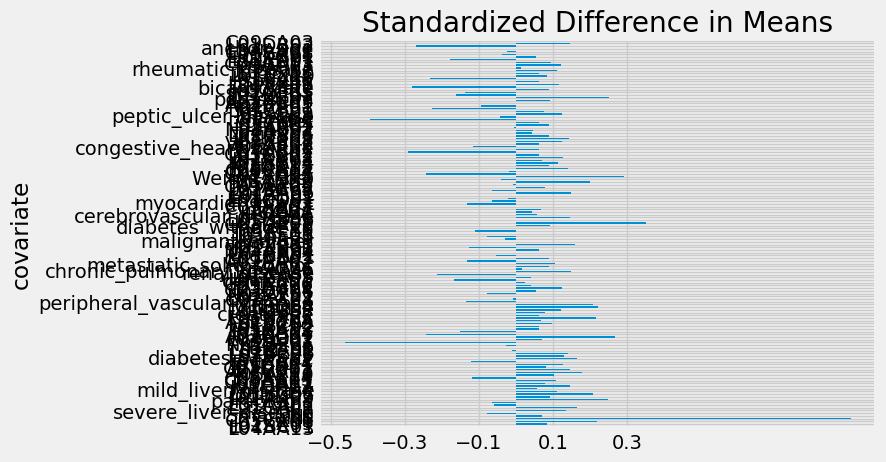

In [ ]:
matched_X_df = pd.DataFrame(matched_X)
matched_X_df.columns = column_dt.columns

smd = (matched_X_df[matched_T==1].mean() - matched_X_df[matched_T==0].mean()).divide(
    np.sqrt((matched_X_df[matched_T==1].std() ** 2 + matched_X_df[matched_T==0].std() ** 2) / 2))

smd.plot.barh(title='Standardized Difference in Means',
           xlabel='covariate',ylabel='standardized difference in means',
           xticks=np.arange(-0.5,0.5,.2))